##### Copyright 2020 The TensorFlow Authors.

In [11]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [12]:
%pip install -U -q tensorflow tensorflow_datasets
%pip install wrapt==1.14.1
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import pathlib
import glob

import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import tensorflow as tf

import subprocess
from IPython import display

import subprocess
import os

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

directory_path_database = "../Tutorial/data/train_files"
directory_path_testfiles = "../Tutorial/data/test_files/"

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [14]:
DATASET_PATH = 'data/train_files'
# DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      # 'mini_speech_commands.zip',
      'train_files.zip',
      # origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      origin="data/train_files.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [15]:
def convert_wav(input_wav, output_wav, sample_rate=16000, channels=1):
    """
    Convert WAV file to a standardized format (Mono, 16kHz)
    """
    command = [
        'ffmpeg', '-i', input_wav, '-ar', str(sample_rate), '-ac', str(channels), output_wav
    ]
    subprocess.run(command, check=True)

def load_wav_file(file_path):
    try:
        # Try to decode the WAV file
        with open(file_path, "rb") as f:
            wav_data = f.read()
        
        audio, sample_rate = tf.audio.decode_wav(wav_data, desired_channels=1, desired_samples=16000)
        print(f"File '{file_path}' successfully decoded!")
        return audio, sample_rate

    except Exception as e:
        print(f"Error decoding WAV file '{file_path}': {e}")
        print("Attempting to convert the file...")

        # Path for the converted file
        converted_file = "converted_temp.wav"
        
        # Convert the WAV file
        convert_wav(file_path, converted_file)
        
        # Load the converted file and try decoding again
        with open(converted_file, "rb") as f:
            wav_data = f.read()
        
        audio, sample_rate = tf.audio.decode_wav(wav_data, desired_channels=1, desired_samples=16000)
        print(f"Converted file '{file_path}' successfully decoded!")
        
        # Remove temporary converted file
        os.remove(converted_file)
        
        return audio, sample_rate

def process_directory(directory_path):
    wav_files = []

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(".wav"):
                wav_files.append(os.path.join(root, file))

    if not wav_files:
        print("No WAV files found in the directory.")
        return

    for file_path in wav_files:
        print(f"Processing file: {file_path}")
        audio, sample_rate = load_wav_file(file_path)
        # Example: Output the shape and sample rate of the audio
        print(f"Audio shape: {audio.shape}, Sample rate: {sample_rate}")


# Example: Specify the directory with WAV files
#directory_path = "../Tutorial/data/test_files"

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [16]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['mp3_128kbit' 'orig_wave' 'upscale_24_48']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [17]:
process_directory(directory_path_database)

seconds=20
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000*seconds,
    subset='both'
    )

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Processing file: ../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In,Elec Guitar,Fiddles.wav
File '../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In,Elec Guitar,Fiddles.wav' successfully decoded!
Audio shape: (16000, 1), Sample rate: 48000
Processing file: ../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In,Guitar Amp,Fiddles.wav
File '../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In,Guitar Amp,Fiddles.wav' successfully decoded!
Audio shape: (16000, 1), Sample rate: 48000
Processing file: ../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In-Out,Elec Guitar 1.wav
File '../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In-Out,Elec Guitar 1.wav' successfully decoded!
Audio shape: (16000, 1), Sample rate: 48000
Processing file: ../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In-Out,Elec Guitar 2.wav
File '../Tutorial/data/train_files\orig_wave\1-4 Inch Plug,In-Out,Elec Guitar 2.wav' successfully decoded!
Audio shape: (16000, 1), Sample rate: 48000
Processing

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [18]:
train_ds.element_spec

(TensorSpec(shape=(None, 320000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [19]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [20]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [21]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 320000)
(64,)


Let's plot a few audio waveforms:

In [22]:
label_names[[1,2,0]]

array(['orig_wave', 'upscale_24_48', 'mp3_128kbit'], dtype='<U13')

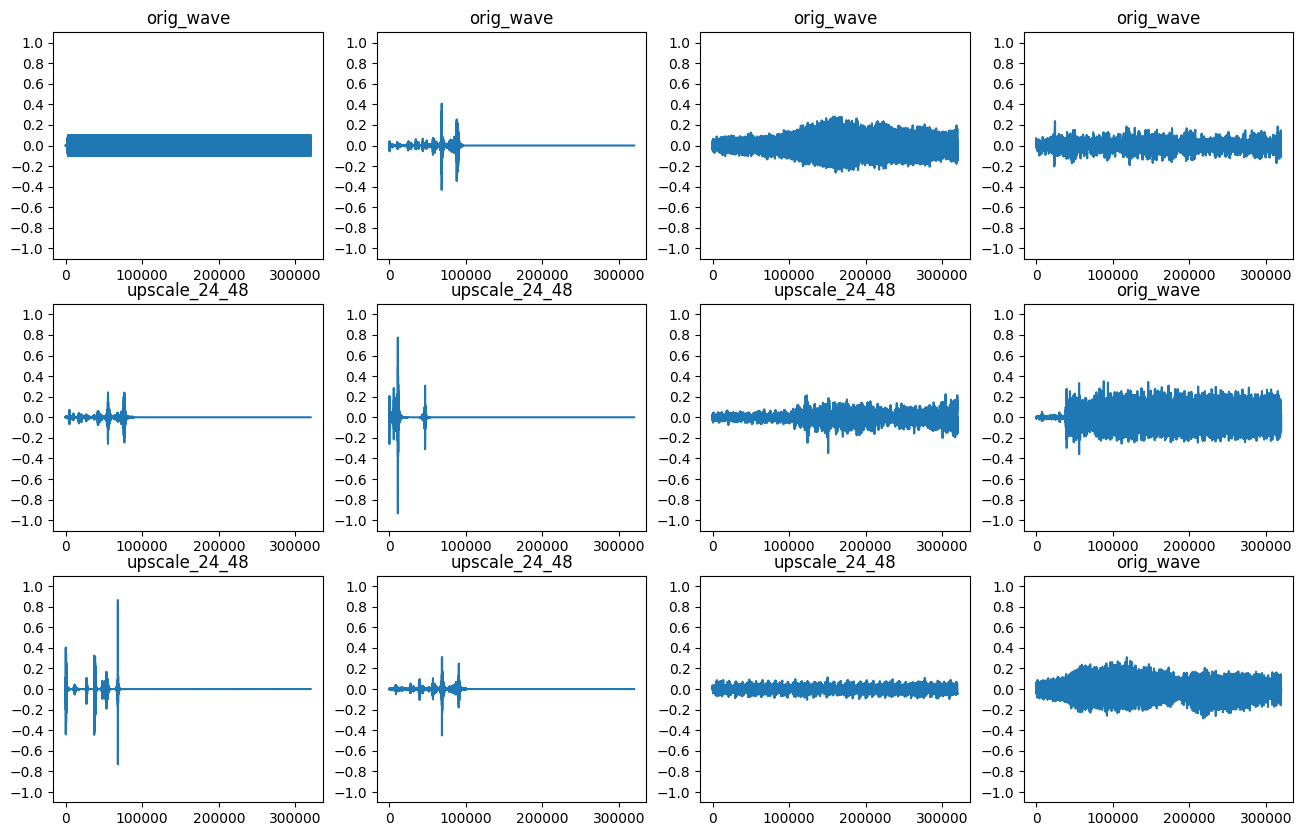

In [23]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 4
n = rows * cols
for i in range(n):
  # print("i ",i)
  # print(label_names)
  # print(example_labels[1])
  # print(example_labels)
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [24]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [25]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: orig_wave
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


Label: orig_wave
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


Label: orig_wave
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [26]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

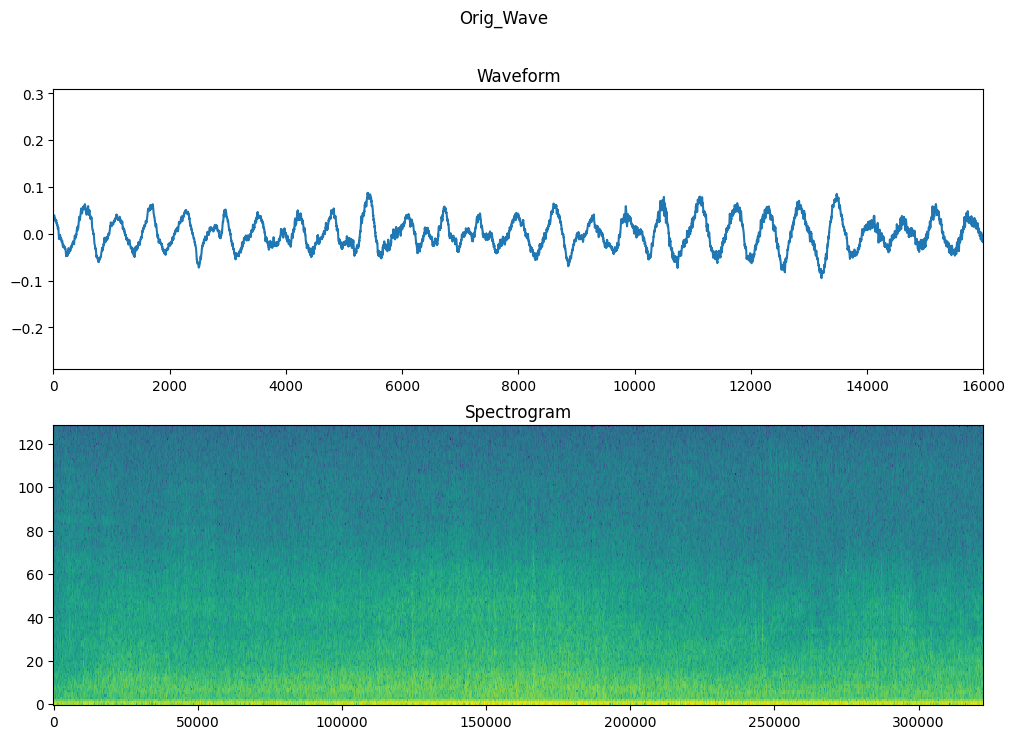

In [27]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [28]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [30]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

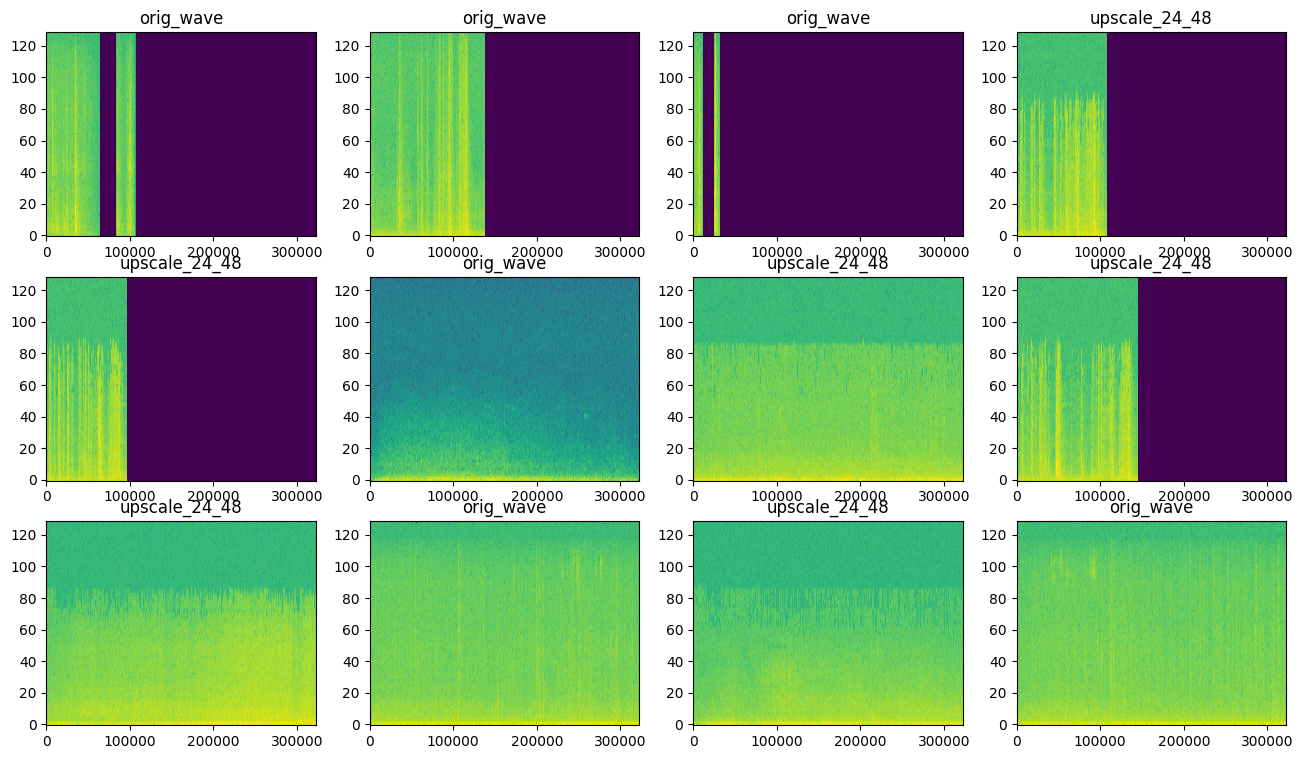

In [31]:
rows = 3
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [32]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [33]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2499, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,966 (6.20 MB)

 Trainable params: 1,624,963 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [35]:
EPOCHS = 200
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.4329 - loss: 1.0747
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6204 - loss: 0.7552
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5417 - loss: 0.7541
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5787 - loss: 0.6810
Epoch 5/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5000 - loss: 0.8439

c:\Users\prett\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
c:\Users\prett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.8228
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5237 - loss: 0.7801
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5567 - loss: 0.8286
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4554 - loss: 0.8382
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4751 - loss: 0.7890
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5133 - loss: 0.8488
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6204 - loss: 0.6294
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6991 - loss: 0.6716
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5515 - loss: 0.7668
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5804 - loss: 0.6999
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5515 - loss: 0.7041
Epoch 16/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6250 - loss: 0.69

Let's plot the training and validation loss curves to check how your model has improved during training:

{'accuracy': [0.4305555522441864, 0.5555555820465088, 0.5, 0.5555555820465088, 0.5, 0.5277777910232544, 0.5694444179534912, 0.4722222089767456, 0.4861111044883728, 0.5277777910232544, 0.5555555820465088, 0.6111111044883728, 0.5694444179534912, 0.5972222089767456, 0.5694444179534912, 0.5, 0.5833333134651184, 0.5694444179534912, 0.5277777910232544, 0.5972222089767456, 0.5972222089767456, 0.5694444179534912, 0.5277777910232544, 0.5277777910232544, 0.6111111044883728, 0.5277777910232544, 0.5416666865348816, 0.5555555820465088, 0.625, 0.5972222089767456, 0.6527777910232544, 0.5555555820465088, 0.5972222089767456, 0.625, 0.5555555820465088, 0.5972222089767456, 0.6805555820465088, 0.6111111044883728, 0.5833333134651184, 0.5972222089767456, 0.6111111044883728, 0.6944444179534912, 0.6805555820465088, 0.6527777910232544, 0.7361111044883728, 0.6805555820465088, 0.6388888955116272, 0.6944444179534912, 0.7083333134651184, 0.75, 0.7222222089767456, 0.6388888955116272, 0.5833333134651184, 0.694444417

Text(0, 0.5, 'Accuracy [%]')

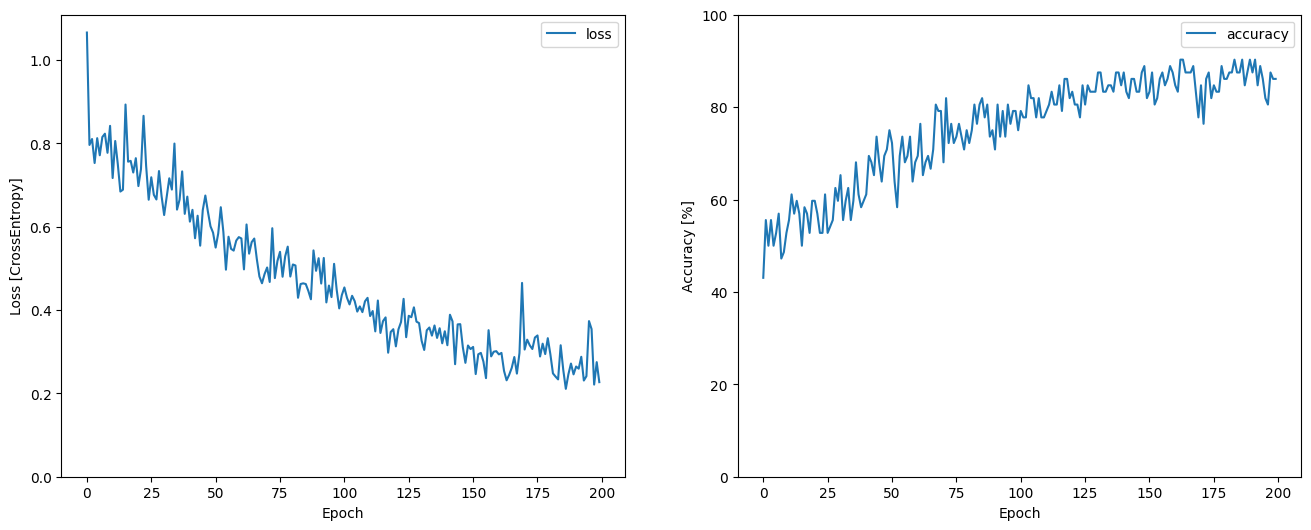

In [36]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
print(metrics)
# plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
# plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [37]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5556 - loss: 3.6010


{'accuracy': 0.5555555820465088, 'loss': 3.601027488708496}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [38]:
y_pred = model.predict(test_spectrogram_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [39]:
y_pred = tf.argmax(y_pred, axis=1)

In [40]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

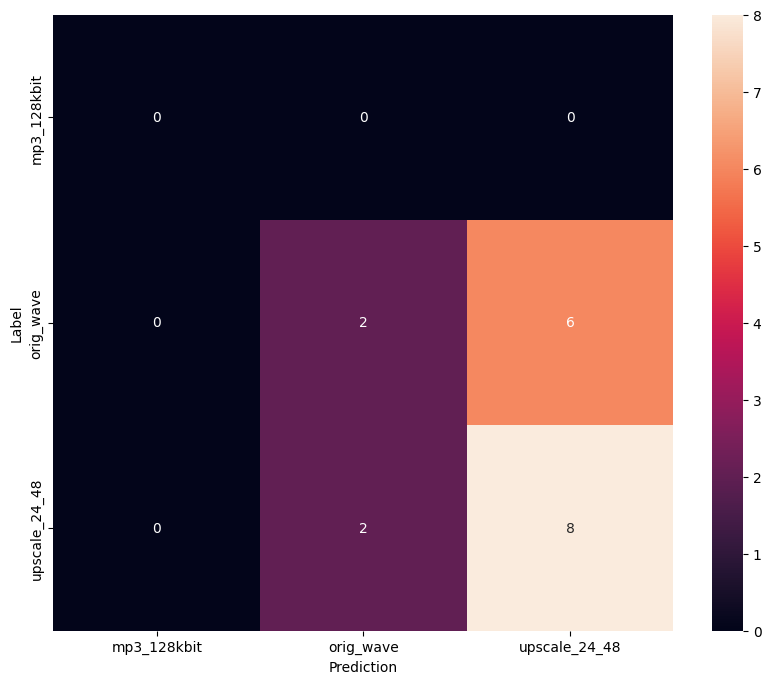

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [42]:
# # x = data_dir/'no/01bb6a2a_nohash_0.wav'
# # x= "../Tutorial/data/test_files/AMBIENCE_JAPAN_THUNDER_HEAVY_RAIN_SLIGHT_WIND_NOISE_STEREO.wav"
# x="../Tutorial/data/test_files/1-900_Hot_date.wav"
# with open(x, "rb") as f:
#     x = f.read()

#     print(len(x))
# # x = tf.io.read_file(str(x))
# x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
# x = tf.squeeze(x, axis=-1)
# waveform = x
# x = get_spectrogram(x)
# x = x[tf.newaxis,...]

# prediction = model(x)
# # x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
# x_labels=label_names
# plt.bar(x_labels, tf.nn.softmax(prediction[0]))
# plt.title('orig')
# plt.show()

# display.display(display.Audio(waveform, rate=16000))

### Read Test File

In [43]:
# # Pfad zur WAV-Datei
# file_path = "../Tutorial/data/test_files/1-900_Hot_date.wav"

# # WAV-Datei im binären Modus lesen
# with open(file_path, "rb") as f:
#     # wav_data = f.read()
#     wav_data = tf.io.read_file(file_path)

# # Prüfen der Länge der gelesenen Daten
# # print(f"Länge der WAV-Daten: {len(wav_data)}")



### Convert to Standard Audio Format if WAVE File Does Not Meet Expectations

In [44]:
# def convert_wav(input_wav, output_wav, sample_rate=16000, channels=1):
#     """
#     Convert WAV file to a standardized format (Mono, 16kHz)
#     """
#     command = [
#         'ffmpeg', '-i', input_wav, '-ar', str(sample_rate), '-ac', str(channels), output_wav
#     ]
#     subprocess.run(command, check=True)

# def load_wav_file(file_path):
#     try:
#         # Try to decode the WAV file
#         with open(file_path, "rb") as f:
#             wav_data = f.read()
        
#         audio, sample_rate = tf.audio.decode_wav(wav_data, desired_channels=1, desired_samples=16000)
#         print(f"File '{file_path}' successfully decoded!")
#         return audio, sample_rate

#     except Exception as e:
#         print(f"Error decoding WAV file '{file_path}': {e}")
#         print("Attempting to convert the file...")

#         # Path for the converted file
#         converted_file = "converted_temp.wav"
        
#         # Convert the WAV file
#         convert_wav(file_path, converted_file)
        
#         # Load the converted file and try decoding again
#         with open(converted_file, "rb") as f:
#             wav_data = f.read()
        
#         audio, sample_rate = tf.audio.decode_wav(wav_data, desired_channels=1, desired_samples=16000)
#         print(f"Converted file '{file_path}' successfully decoded!")
        
#         # Remove temporary converted file
#         os.remove(converted_file)
        
#         return audio, sample_rate

# def process_directory(directory_path):
#     # Find all WAV files in the directory
#     wav_files = glob.glob(os.path.join(directory_path, "*.wav"))

#     if not wav_files:
#         print("No WAV files found in the directory.")
#         return

#     for file_path in wav_files:
#         print(f"Processing file: {file_path}")
#         audio, sample_rate = load_wav_file(file_path)
#         # Example: Output the shape and sample rate of the audio
#         print(f"Audio shape: {audio.shape}, Sample rate: {sample_rate}")

# # Example: Specify the directory with WAV files
# #directory_path = "../Tutorial/data/test_files"
# #process_directory(directory_path)

Verarbeite Datei: ../Tutorial/data/test_files\1-900_Hot_date.wav
Error decoding WAV file '../Tutorial/data/test_files\1-900_Hot_date.wav': {{function_node __wrapped__DecodeWav_device_/job:localhost/replica:0/task:0/device:CPU:0}} Data too short when trying to read string [Op:DecodeWav]
Attempting to convert the file...
Converted file '../Tutorial/data/test_files\1-900_Hot_date.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 16000


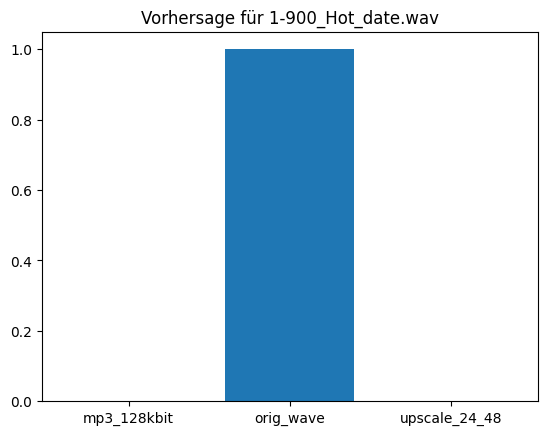

Verarbeite Datei: ../Tutorial/data/test_files\4WD_HUMVEE_MANOUVER_FAST_INTERIOR01.wav
File '../Tutorial/data/test_files\4WD_HUMVEE_MANOUVER_FAST_INTERIOR01.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 48000


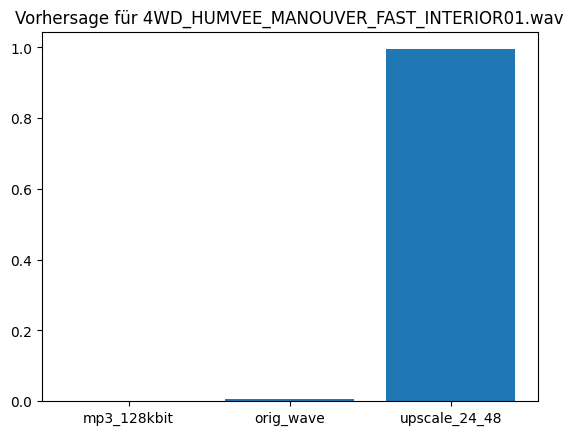

Verarbeite Datei: ../Tutorial/data/test_files\4WD_HUMVEE_SLOW_SHUTDOWN_INTERIOR01.wav
File '../Tutorial/data/test_files\4WD_HUMVEE_SLOW_SHUTDOWN_INTERIOR01.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 48000


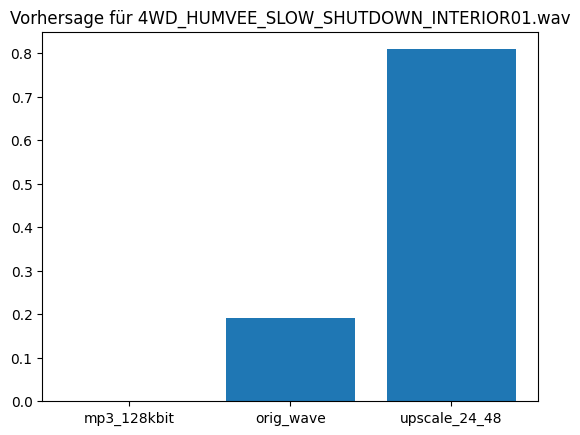

Verarbeite Datei: ../Tutorial/data/test_files\AMBIENCE_JAPAN_THUNDER_HEAVY_RAIN_SLIGHT_WIND_NOISE_STEREO.wav
File '../Tutorial/data/test_files\AMBIENCE_JAPAN_THUNDER_HEAVY_RAIN_SLIGHT_WIND_NOISE_STEREO.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 44100


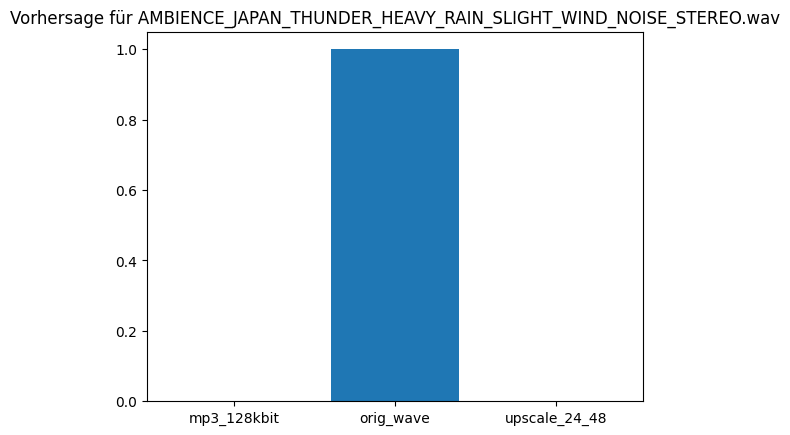

Verarbeite Datei: ../Tutorial/data/test_files\mp3_4WD_HUMVEE_SLOW_SHUTDOWN_INTERIOR01.wav
File '../Tutorial/data/test_files\mp3_4WD_HUMVEE_SLOW_SHUTDOWN_INTERIOR01.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 48000


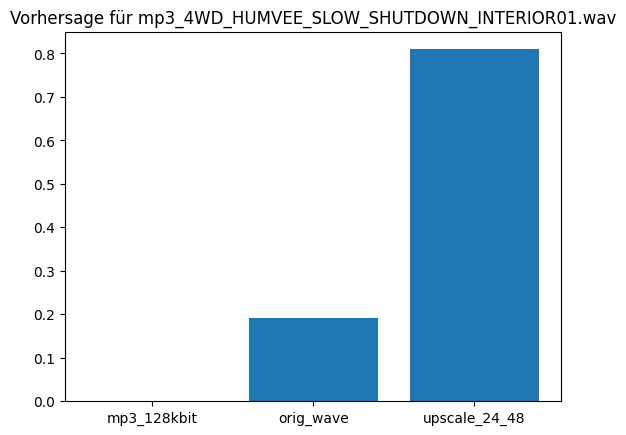

Verarbeite Datei: ../Tutorial/data/test_files\upscale_1-900_Physic.wav
File '../Tutorial/data/test_files\upscale_1-900_Physic.wav' successfully decoded!
Form des Audiosignals: (16000,)
Sample Rate: 48000


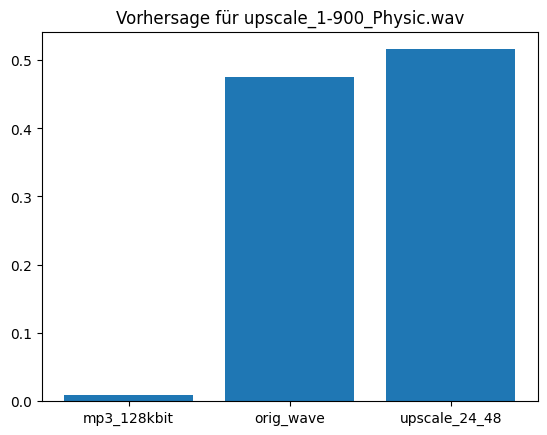

In [45]:
# # WAV-Daten decodieren
# audio, sample_rate = tf.audio.decode_wav(
#     wav_data,
#     desired_channels=1,  # In Mono umwandeln (1 Kanal)
#     desired_samples=16000,  # Maximale Anzahl von Samples
# )
def visualize_audio(file_path):
    try:
       audio, sample_rate = load_wav_file(file_path)
    except Exception as e:
        print(f"Could not process file '{file_path}': {e}")
        return
    # Entfernen der letzten Achse, falls nur ein Kanal vorliegt
    waveform = tf.squeeze(audio, axis=-1)

    # Überprüfen der Form des Audiosignals
    print(f"Form des Audiosignals: {waveform.shape}")
    print(f"Sample Rate: {sample_rate}")

    # Umwandeln in ein Spektrogramm (hier nehme ich an, dass `get_spectrogram` existiert)
    spectrogram = get_spectrogram(waveform)

    # Dimension anpassen für das Modell
    input_tensor = spectrogram[tf.newaxis, ...]

    # Vorhersage des Modells
    prediction = model(input_tensor)

    # Labels für die Vorhersage
    x_labels = label_names  # Annahme: 'label_names' ist definiert

    # Balkendiagramm der Vorhersagen anzeigen
    plt.bar(x_labels, tf.nn.softmax(prediction[0]))
    plt.title(f'Vorhersage für {os.path.basename(file_path)}')
    plt.show()

    # Audio im Notebook abspielen
    display.display(display.Audio(waveform, rate=16000))

def process_directory_for_visualization(directory_path):
    # Find all WAV files in the directory
    wav_files = glob.glob(os.path.join(directory_path, "*.wav"))

    if not wav_files:
        print("Keine WAV-Dateien im Verzeichnis gefunden.")
        return

    for file_path in wav_files:
        print(f"Verarbeite Datei: {file_path}")
        visualize_audio(file_path)

# Beispiel: Verzeichnis mit WAV-Dateien angeben
#directory_path = "../Tutorial/data/test_files"
process_directory_for_visualization(directory_path_testfiles)

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [46]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [47]:
export = ExportModel(model)
# export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))
export(tf.constant(str("../Tutorial/data/test_files/AMBIENCE_JAPAN_THUNDER_HEAVY_RAIN_SLIGHT_WIND_NOISE_STEREO.wav")))

{'predictions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-16.059975,   7.960486,  -2.794871]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'orig_wave'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [48]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * <tf.Tensor 'x:0' shape=(1, 320000) dtype=float32>
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(), dtype=tf.string, name='x')
  Keyword arguments: {}

Option 2:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 16000), dtype=tf.float32, name='x')
  Keyword arguments: {}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.